# California vehicle fuel type count by zip code

### Load Python tools

In [1]:
import pandas as pd
import geopandas as gpd
import pyarrow
import matplotlib
import matplotlib.pyplot as plt
import geojson
import json
import jenkspy
import numpy as np
from earthpy import clip as cl
from altair import datum
import weightedcalcs as wc
import altair as alt
alt.renderers.enable('notebook')
import altair_latimes as lat
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')
pd.options.display.max_columns = 50
pd.options.display.max_rows = 1000

### Read data from California Department of Motor Vehicles - current as of October 2018

In [2]:
#https://data.ca.gov/dataset/vehicle-fuel-type-count-by-zip-code
src = pd.read_csv('https://data.ca.gov/dataset/15179472-adeb-4df6-920a-20640d02b08c/\
resource/d304108a-06c1-462f-a144-981dd0109900/\
download/vehicle-fuel-type-count-by-zip-code.csv', low_memory=False)

In [3]:
src.head()

,Date,Zip Code,Model Year,Fuel,Make,Duty,Vehicles
0,10/1/2018,90000,2006,Gasoline,OTHER/UNK,Light,1
1,10/1/2018,90000,2014,Gasoline,OTHER/UNK,Light,1
2,10/1/2018,90000,2016,Gasoline,OTHER/UNK,Light,1
3,10/1/2018,90000,2017,Gasoline,OTHER/UNK,Light,1
4,10/1/2018,90000,<2006,Diesel and Diesel Hybrid,OTHER/UNK,Heavy,55


### Clean up headers, field names

In [4]:
src.columns = src.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

In [5]:
src.rename(columns={"zip_code": "zip"}, inplace=True)

### How many vehicles are we talking about? 

In [6]:
src.vehicles.sum()

31137994

### Remove few 2019 models, older models and those listed as out of service

In [7]:
src = src[(src['model_year'] != '2019') & (src['model_year'] != '<2006') & (src['zip'] != 'OOS')]

### What's left?

In [8]:
src.vehicles.sum()

19485599

### How many don't rely solely on gasoline?

In [9]:
nongas = src[(src['fuel'] != 'Gasoline')]

In [10]:
nongas.vehicles.sum()

3213912

### Group by make. Which are most common? 

In [11]:
make = src.groupby(['make']).agg('sum').reset_index()

In [12]:
make.sort_values(by='vehicles', ascending=False).head(10)

,make,vehicles
85,TOYOTA,3477549
66,OTHER/UNK,2547304
36,HONDA,2324083
28,FORD,1666619
16,CHEVROLET,1347288
63,NISSAN,1326031
11,BMW,597454
38,HYUNDAI,595488
50,LEXUS,593341
55,MERCEDES-BENZ,587839


### Group by model year. Which years have the most vehicles? 

In [13]:
model_year = src.groupby(['model_year']).agg('sum').reset_index()

In [14]:
model_year.sort_values(by='model_year', ascending=False)

,model_year,vehicles
12,2018,1572034
11,2017,2141868
10,2016,2072606
9,2015,2002628
8,2014,1677875
7,2013,1644620
6,2012,1354947
5,2011,1101920
4,2010,996703
3,2009,834319


### Which types of alternative fuel models are most common?

In [15]:
fuel = nongas.groupby(['fuel']).agg('sum').reset_index()

In [16]:
fuel.sort_values(by='vehicles', ascending=False)

,fuel,vehicles
2,Flex-Fuel,1018550
3,Hybrid Gasoline,994696
1,Diesel and Diesel Hybrid,753609
0,Battery Electric,214671
7,Plug-in Hybrid,201969
5,Natural Gas,22968
4,Hydrogen Fuel Cell,5092
6,Other,2357


### Chart the fuel type counts

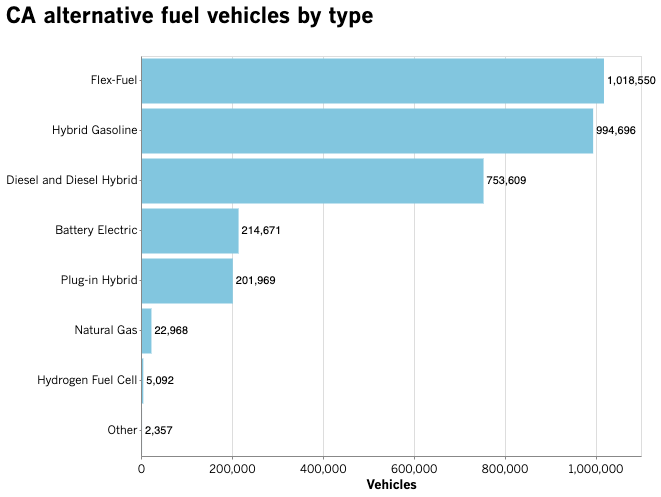

In [17]:
chart_fuels = alt.Chart(fuel).mark_bar().encode(
    y=alt.Y('fuel:N', title=' ',
        sort=alt.EncodingSortField(
            field="vehicles",  # The field to use for the sort
            op="sum",  # The operation to run on the field prior to sorting
            order="descending"  # The order to sort in
        ), axis=alt.Axis(format='', tickCount=5)),
    x=alt.X("sum(vehicles):Q", title="Vehicles", axis=alt.Axis(format='', tickCount=5))
)

chart_fuels_text = chart_fuels.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(text=alt.Text('sum(vehicles)', format=',')
)


(chart_fuels + chart_fuels_text)\
.properties(height=400, width=500, title='CA alternative fuel vehicles by type')

--- 

## Where are these vehicles?

In [18]:
zip_code = src.groupby(['zip']).agg('sum').reset_index()

In [19]:
zip_code_nongas = nongas.groupby(['zip']).agg('sum').reset_index()

### Which ZIP codes have the most alternative fuel vehicles? (Airport areas, it seems)

In [20]:
zip_code_nongas.sort_values(by='vehicles',\
    ascending=False).head(10)

,zip,vehicles
44,90045,18010
1476,94080,10747
904,92626,10514
1017,92868,9989
11,90012,9493
1170,93308,9377
756,92335,8906
1438,94010,8822
417,91710,8724
592,92101,8457


### Pivot on ZIP code and widen out the dataframe to count vehicle types across them

In [21]:
sum_by_zip = pd.pivot_table(src, values='vehicles', \
                            index=['zip'], columns=['fuel'], aggfunc=np.sum, fill_value=0).reset_index()

sum_by_zip.columns = sum_by_zip.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

### Which type is most common in each ZIP code? 

In [22]:
sum_by_zip["total"] = sum_by_zip.sum(axis=1)

In [23]:
sum_by_zip.sort_values(by='total', ascending=False).head(5)

fuel,zip,battery_electric,diesel_and_diesel_hybrid,flex_fuel,gasoline,hybrid_gasoline,hydrogen_fuel_cell,natural_gas,other,plug_in_hybrid,total
45,90045,420,605,11978,109120,4466,19,138,0,384,127130
1520,94080,307,1519,3761,92399,4872,9,38,2,239,103146
782,92336,180,1706,2664,46467,1736,7,31,0,443,53234
660,92154,115,4196,2154,42291,1256,0,4,0,140,50156
426,91709,533,1139,1847,41681,2389,36,30,1,717,48373


### Group the lesser-used fuel types into an 'other' category

In [24]:
sum_by_zip['other'] = sum_by_zip.apply\
    (lambda x: x['hydrogen_fuel_cell'] + x['natural_gas'] + x['other'], axis=1)
sum_by_zip.drop(['hydrogen_fuel_cell', 'natural_gas'], axis=1, inplace=True)
sum_by_zip.drop([0], inplace=True)

### Which non-gas vehicle is most popular — the 'winner' — in each zip?

In [25]:
sum_by_zip['winner'] = \
sum_by_zip[['hybrid_gasoline','battery_electric','diesel_and_diesel_hybrid',\
                   'flex_fuel','plug_in_hybrid', 'other']].idxmax(axis=1)

In [26]:
sum_by_zip.sort_values(by='total', ascending=False).head(5)

fuel,zip,battery_electric,diesel_and_diesel_hybrid,flex_fuel,gasoline,hybrid_gasoline,other,plug_in_hybrid,total,winner
45,90045,420,605,11978,109120,4466,157,384,127130,flex_fuel
1520,94080,307,1519,3761,92399,4872,49,239,103146,hybrid_gasoline
782,92336,180,1706,2664,46467,1736,38,443,53234,flex_fuel
660,92154,115,4196,2154,42291,1256,4,140,50156,diesel_and_diesel_hybrid
426,91709,533,1139,1847,41681,2389,67,717,48373,hybrid_gasoline


### De-slugify the 'winner' category

In [27]:
sum_by_zip['winner'] = sum_by_zip['winner'].str.replace('_', ' ', regex=False).str.capitalize()

In [28]:
sum_by_zip.head()

fuel,zip,battery_electric,diesel_and_diesel_hybrid,flex_fuel,gasoline,hybrid_gasoline,other,plug_in_hybrid,total,winner
1,90001,10,508,820,15406,413,4,44,17205,Flex fuel
2,90002,22,300,753,14110,386,2,27,15600,Flex fuel
3,90003,16,366,885,18507,522,10,39,20345,Flex fuel
4,90004,248,265,443,19940,1878,16,251,23041,Hybrid gasoline
5,90005,71,126,217,11052,857,8,105,12436,Hybrid gasoline


### Use the "jenks" method to set fair breaks for total field

In [29]:
breaks \
= jenkspy.jenks_breaks(sum_by_zip.total, nb_class=7)

In [30]:
breaks

[1.0, 3499.0, 9905.0, 16350.0, 23391.0, 32528.0, 53234.0, 127130.0]

---

# Geography data

### ZIP code points

In [31]:
zips_point = gpd.read_file('/Users/mhustiles/data/data/GIS/zipcodes.geojson')

In [32]:
zips_point['zip'] = zips_point['zip'].astype(str)

In [33]:
ca_zips_point = zips_point[zips_point['state'] == 'CA']

### ZIP code boundaries

In [34]:
zips_poly = gpd.read_file('/Users/mhustiles/data/data/GIS/californiazips.geojson')

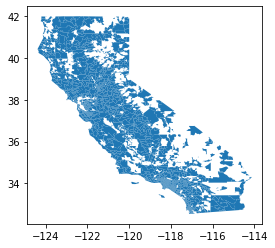

In [35]:
zips_poly.plot()

In [36]:
zips_poly.rename(columns={"ZCTA5CE10": "zip"}, inplace=True)

### Merge with pivoted zip totals

In [37]:
ca_zips_poly_merged =  zips_poly.merge(sum_by_zip, on='zip')

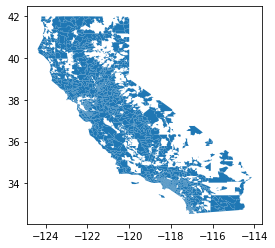

In [38]:
ca_zips_poly_merged.plot()

In [39]:
ca_zips_poly_merged.loc[0]

zip                                                                     94118
INTPTLAT10                                                        +37.7800933
INTPTLON10                                                       -122.4626054
geometry                    (POLYGON ((-122.470081 37.787399, -122.467989 ...
battery_electric                                                          302
diesel_and_diesel_hybrid                                                  230
flex_fuel                                                                 218
gasoline                                                                12561
hybrid_gasoline                                                          1701
other                                                                       7
plug_in_hybrid                                                            200
total                                                                   15219
winner                                                        Hy

### Export merged polygon geodataframe as GeoJSON

In [40]:
ca_zips_poly_merged.to_file('/Users/mhustiles/data/github/notebooks/\
california-fuel-vehicles/output/ca_zips_poly_merged.geojson', driver='GeoJSON')

### Merge ZIP points with vehicle totals

In [41]:
ca_zips_point_merged = ca_zips_point.merge(sum_by_zip, on='zip')

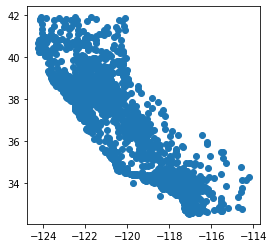

In [42]:
ca_zips_point_merged.plot()

### Export merged points geodataframe as GeoJSON

In [43]:
ca_zips_point_merged.to_file('/Users/mhustiles/data/github/notebooks\
/california-fuel-vehicles/output/ca_zips_point_merged.geojson', driver='GeoJSON')

### Convert polygons to mbtiles for Mapbox. Export.

In [44]:
!tippecanoe --force -r1 -pk -pf -Z5 -z13 -o \
/Users/mhustiles/data/github/notebooks/california-fuel-vehicles/output/ca_zips_poly_merged.mbtiles \
/Users/mhustiles/data/github/notebooks/california-fuel-vehicles/output/ca_zips_poly_merged.geojson

For layer 0, using name "ca_zips_poly_merged"
1760 features, 9359146 bytes of geometry, 56252 bytes of separate metadata, 83813 bytes of string pool
  99.9%  13/1345/3147  


### Convert points to mbtiles for Mapbox. Export.

In [45]:
!tippecanoe --force -r1 -pk -pf -Z5 -z13 -o \
/Users/mhustiles/data/github/notebooks/california-fuel-vehicles/output/ca_zips_point_merged.mbtiles \
/Users/mhustiles/data/github/notebooks/california-fuel-vehicles/output/ca_zips_point_merged.geojson

For layer 0, using name "ca_zips_point_merged"
2421 features, 146776 bytes of geometry, 16 bytes of separate metadata, 54710 bytes of string pool
  99.9%  13/1370/3196  


---

See related [Twitter thread](https://twitter.com/stiles/status/1193416749116358656)